In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')
# Gaussian family initialization
family = Gaussian()
np.set_printoptions(precision=3, suppress=True)

#### DGP

- Create census tracts (polygon) and points with the same grid extents i.e 0-1200

In [2]:
# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 1200
ymin, ymax = 0, 1200

- Adjust the step size of the grid to increase or decrease the size of the tracts, so it has more or less points in it.

- The Census tracts are S1 (target supports). I also simulate S2 points and corresponding locations, with a mean of 50 and standard deviation of 30. 

In [3]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 25, 25  # Creates a 48x48 grid, resulting in 2304 tracts cell divisions
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

# This is the step where I choose the size of the tracts 
x_step, y_step = 25, 25  # Creates a 48x48 grid, resulting in 2304 tracts cell divisions
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, background_points, num_clusters, cluster_std=5, x_range=(0, 1200), y_range=(0, 1200), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    clustered_locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    clustered_locations[:, 0] = np.clip(clustered_locations[:, 0], x_range[0], x_range[1])
    clustered_locations[:, 1] = np.clip(clustered_locations[:, 1], y_range[0], y_range[1])

    background_locations = np.random.uniform(low=[x_range[0], y_range[0]], high=[x_range[1], y_range[1]], 
                                             size=(background_points, 2))
   
    all_locations = np.vstack((clustered_locations, background_locations))
    # Generate S2 values (normally distributed, similar to the original code)
    S2 = np.random.normal(50, 30, num_points+background_points)
    
    return S2, all_locations

S2, loc2 = simulate_clustered_S2(num_points=2000, background_points=1200, num_clusters=15, cluster_std=30, random_state=12)

#### Plot tracts and points

In [4]:
len(tracts_gdf48), len(S2)

(2304, 3200)

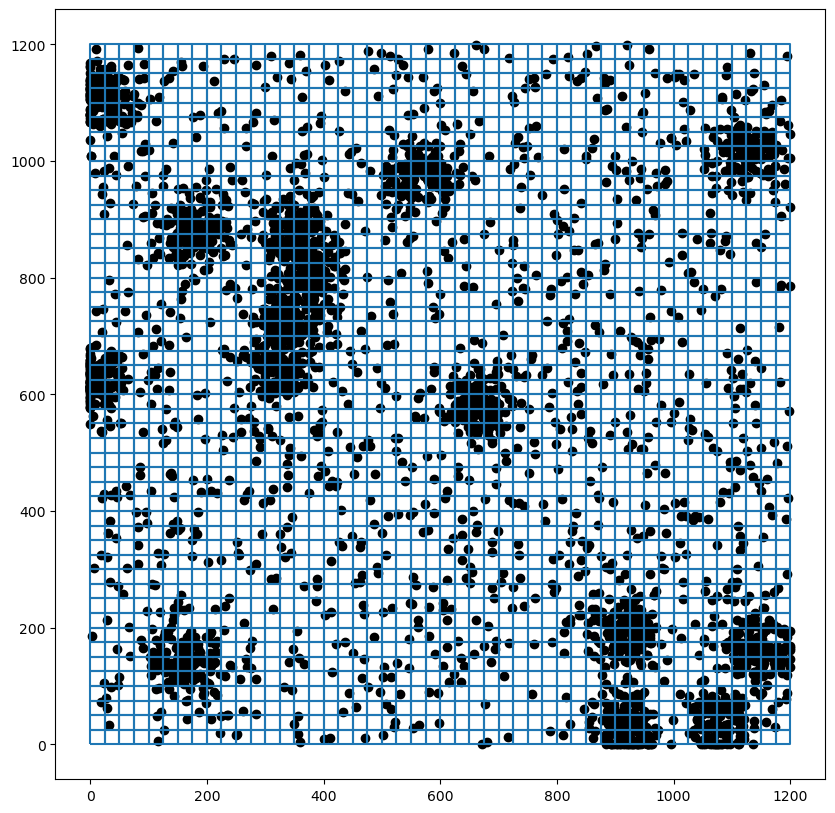

In [5]:
# plt.figure(figsize=(9,5))
tracts_gdf48.boundary.plot(figsize=(10,10))
plt.scatter(loc2[:,0], loc2[:,1], color='k');

<br />

Rather than aggregating the points in each tract, the broad idea is to smooth the points around the centroid of each tracts and calibrate local regression with the smoothed values.

In [6]:
len(tracts_gdf48), len(S2)

(2304, 3200)

#### Create different beta surfaces and base DGP

 --> S1 denotes census tracts <br />
 --> S2 denotes points<br />
 --> loc1 denotes centroids of the census tracts<br />
 --> loc2 denotes the locations of the S2 points<br />

In [7]:
S1 = tracts_gdf48
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2

In [8]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    
    if heterogeneity == 'low':
        B = x / 600 + y / 600
    elif heterogeneity == 'high':
        B = np.sin(x/120) * np.cos(y/120) + (x-600)**2/1200 + (y-600)**2/1200

    Bmin, Bmax = np.min(B), np.max(B)
    B_norm = (B - Bmin) / (Bmax - Bmin) 
    B_scaled = 1 + B_norm*4
    return B_scaled
    
def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


B = create_beta_surface(loc1, heterogeneity='high')

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])


y_orig = B * smoothed_S2_to_S1 

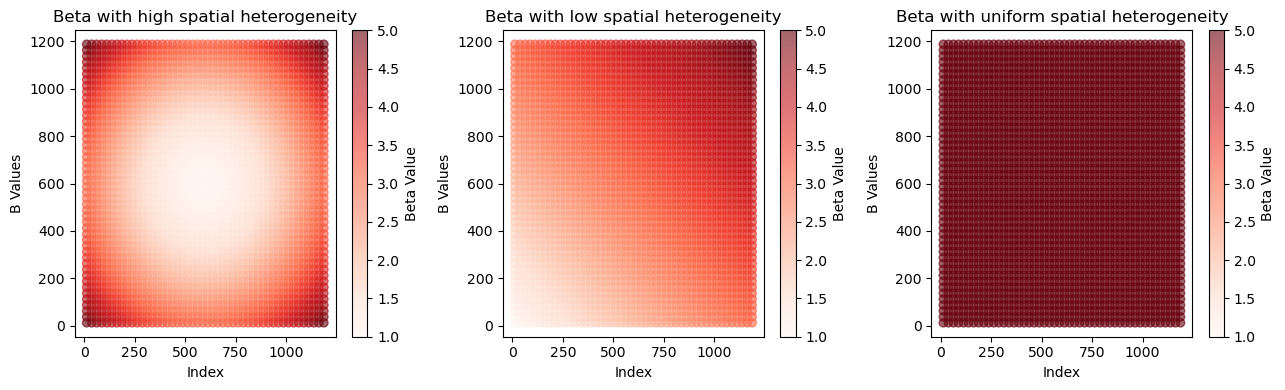

In [9]:
# Initialize beta

Beta_H = create_beta_surface(loc1, heterogeneity='high')
Beta_L = create_beta_surface(loc1, heterogeneity='low')
Beta_U = uniform(loc1)

plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_H, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with high spatial heterogeneity')

plt.subplot(1, 3, 2)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_L, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with low spatial heterogeneity')

plt.subplot(1, 3, 3)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_U, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with uniform spatial heterogeneity')


plt.tight_layout()
plt.show()


#### Helper function

In [10]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    sigma2 = RSS / (n - tr_S)  # Correct variance calculation
    term1 = n * np.log(sigma2)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc

    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc


def log_likelihood_gaussian(residuals, n, tr_S):
    """Calculate log-likelihood for Gaussian model with trace of hat matrix."""
    sigma2 = np.sum(residuals**2) / (n - tr_S)  
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    

def plot_true_and_recovered(true, recovered, coord, name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values ')
    plt.colorbar(label='Beta Value')
    plt.title(f'True B Values for {name}')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title(f'recovered B Values for {name}')
    
    plt.tight_layout()
    plt.show()

<br />

#### perform cos local regression

In [11]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function that implements change of support into a GWR-like local model
    """
    N = len(loc1)
    recovered_betas = np.zeros(N)
    residuals = np.zeros(N)
    S = np.zeros((N, N))
    family = Gaussian() 

    # Code refactoring -> Initialize NearestNeighbors outside the loop (no need to run it everytime inside loop)
    nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
    nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)

    # Pre-compute smoothed S2 onto all S1 locations
    smoothed_S2 = np.zeros(N)
    for i in range(N):
        # Find neighbors in S2 for current S1_i for smoothing
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        bw_S2 = distances_S1_to_S2[0][-1]  # Bandwidth for S2

        distances_X = distances_S1_to_S2[0]
        weights_X = np.exp(-0.5 * (distances_X / bw_S2)**2)
        local_X = S2[indices_S1_to_S2[0]]
        smoothed_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)

    for i in range(N):
        # Local regression using smoothed S2 data at neighboring S1 locations
        # Find neighbors in S1 for current S1_i
        distances_S1_to_S1, indices_S1_to_S1 = nbrs_S1.kneighbors([loc1[i]])
        bw_S1 = distances_S1_to_S1[0][-1]  # Bandwidth for S1

        y_neighbors = y[indices_S1_to_S1[0]].reshape(-1, 1)
        X_neighbors = smoothed_S2[indices_S1_to_S1[0]].reshape(-1, 1)

        distances_y = distances_S1_to_S1[0]
        weights_y = np.exp(-0.5 * (distances_y / bw_S1)**2).reshape(-1, 1)

        # Perform WLS regression
        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 40, wi=weights_y)
        betas = rslt[0]  # Extract betas

        recovered_betas[i] = betas[0] 

        # Compute residuals
        y_pred_i = X_neighbors[0, 0] * betas[0]
        residuals[i] = y[i] - y_pred_i

        # Compute leverage h_ii for hat matrix diagonal
        W = np.diag(weights_y.flatten())
        XTWX = X_neighbors.T @ W @ X_neighbors

        # Regularize XTWX if necessary to prevent singularity
        XTWX += np.eye(XTWX.shape[0]) * 1e-8
        XTWX_inv = np.linalg.inv(XTWX)
        
        # Compute h_ii
        x_i = X_neighbors[0, :].reshape(-1,1)
        w_i = weights_y[0,0]
        
        h_ii = (x_i.T @ XTWX_inv @ x_i) * w_i
        S[i, i] = h_ii

    RSS = np.sum(residuals**2)

    # Calculate trace of S
    tr_S = np.trace(S)
    
    # print(smoothed_S2)

    # Calculate AICc
    log_likelihood = log_likelihood_gaussian(residuals, len(S1), tr_S) # not used
    aicc_ll = calculate_aicc(len(S1), log_likelihood, tr_S) # not used
   
    aicc = calculate_aicc_rss(N, RSS, tr_S)

    return recovered_betas, aicc_ll, tr_S

### I am starting by setting size of the tracts to 48x48. Making each tract a small area initially. Then I subsequently expand this size

#### local-gass computation

In [12]:
S1 = tracts_gdf48
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2

In [13]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 100))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_orig)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 102
Best AICc: 17480.20


In [14]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

102

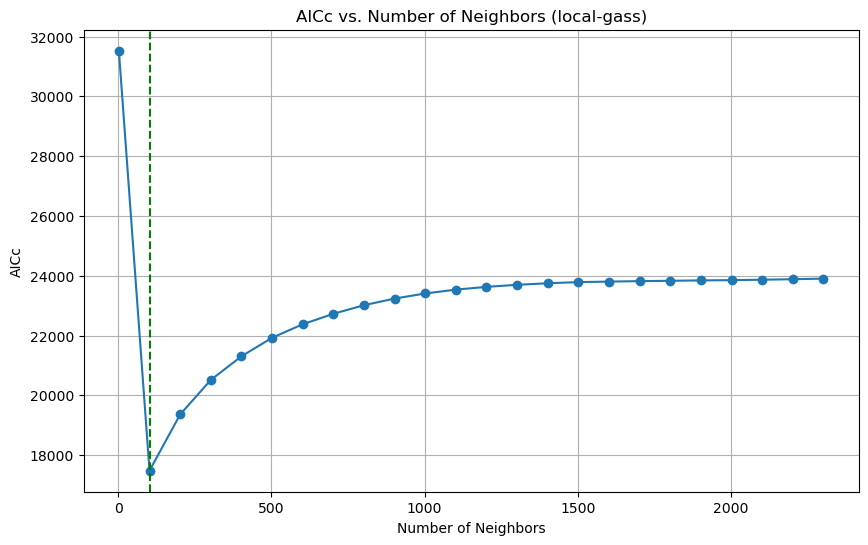

In [15]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors (local-gass)')
plt.grid(True)
plt.show()

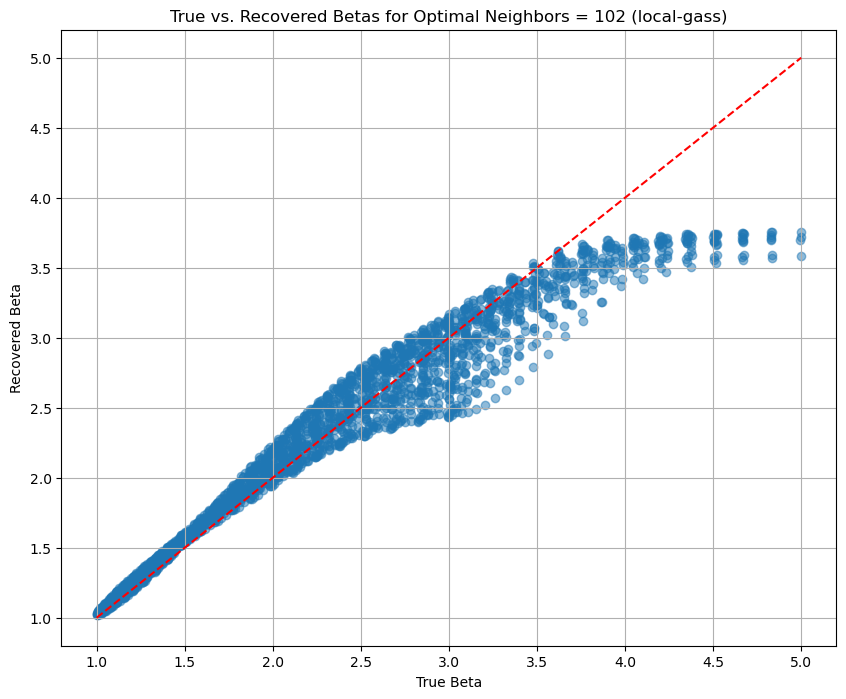

In [16]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
# val = 40
# single, aicc, enp = perform_local_regression(val, loc1, loc2, S2, y)

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} (local-gass)')
plt.grid(True) 
plt.show()

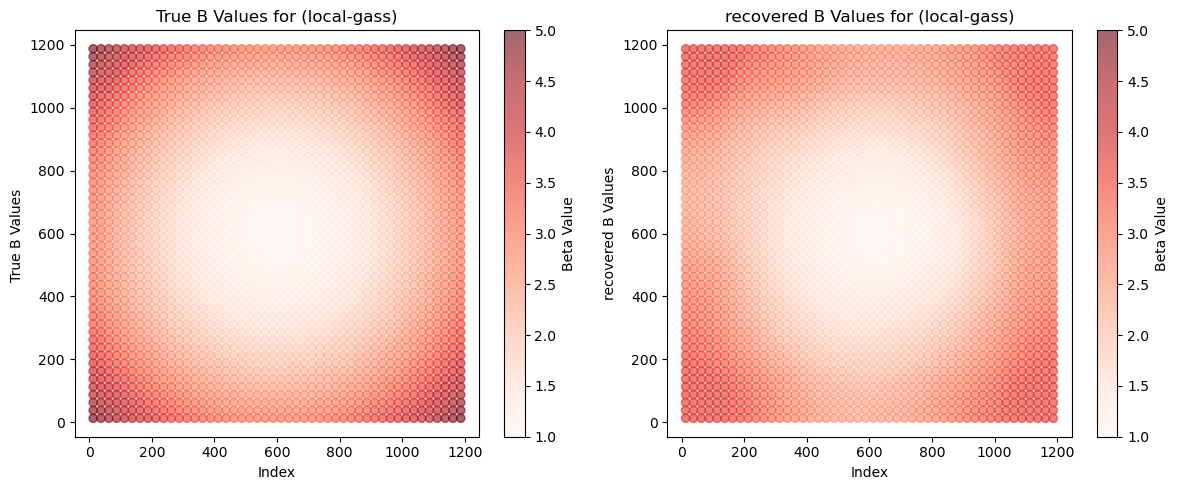

In [17]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass)')

In [18]:
B

array([4.998, 4.831, 4.672, ..., 4.675, 4.834, 5.   ])

In [19]:
recovered_betas_best.round(1)

array([3.8, 3.8, 3.8, ..., 3.6, 3.6, 3.6])

In [20]:
B.min(), B.max()

(1.0, 5.0)

In [21]:
recovered_betas_best.min(), recovered_betas_best.max()

(1.0208793549210604, 3.755541555768558)

<br />
<br />
<br />

#### Aggregating points into census tracts for GWR

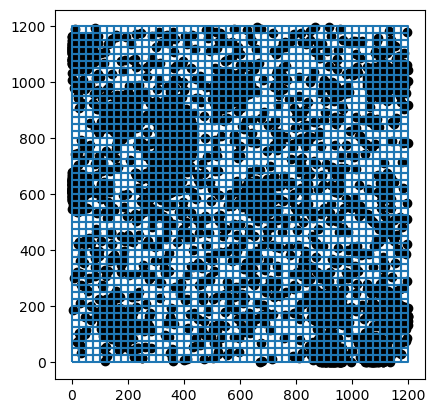

In [22]:
tracts_gdf48.boundary.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [23]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))

In [24]:
df_S2.head()

S2                   geometry
0  41.818074    POINT (940.176 231.633)
1   7.524071    POINT (557.503 992.871)
2  13.774771    POINT (41.548 1095.605)
3  47.419181  POINT (1132.238 1003.127)
4  16.514588   POINT (1122.092 976.718)

<Axes: >

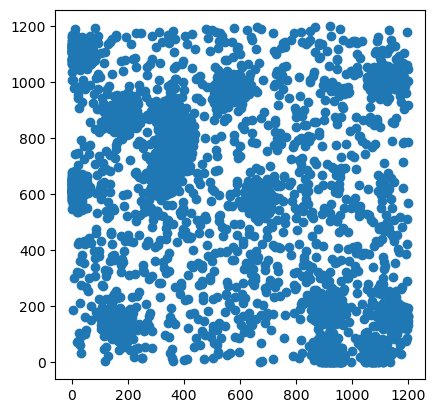

In [25]:
df_S2.plot()

#### Spatial Join and mean-aggregation

In [26]:
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')

In [27]:
joined.head()

S2                 geometry  index_right  tract_id
0     41.818074  POINT (940.176 231.633)         1785      1785
222   -0.765320  POINT (933.213 248.095)         1785      1785
1058  65.977743  POINT (945.030 229.483)         1785      1785
1942  70.489245  POINT (928.528 237.644)         1785      1785
1      7.524071  POINT (557.503 992.871)         1095      1095

<Axes: >

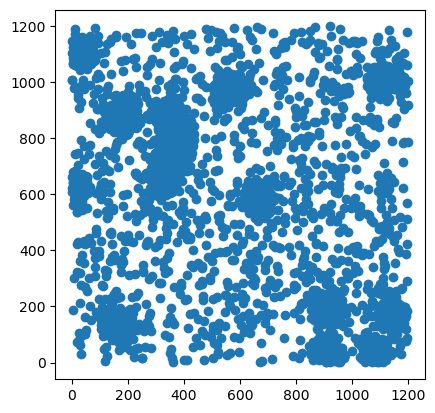

In [28]:
joined.plot()

In [29]:
sX = joined.groupby('tract_id').agg({'S2': ['mean']})#.reset_index()

In [30]:
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

In [31]:
# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')

In [32]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 25.000 0.000, 25.000 25...        NaN
1         1  POLYGON ((0.000 25.000, 25.000 25.000, 25.000 ...        NaN
2         2  POLYGON ((0.000 50.000, 25.000 50.000, 25.000 ...  79.321963
3         3  POLYGON ((0.000 75.000, 25.000 75.000, 25.000 ...        NaN
4         4  POLYGON ((0.000 100.000, 25.000 100.000, 25.00...  95.004654

In [33]:
sX1.isna().sum()

tract_id       0
geometry       0
S2_mean     1138
dtype: int64

##### 523 missing values after spatial join. This speaks to one of the drawbacks of using this method

In [34]:
sX1.fillna({'S2_mean': 0}, inplace=True)

In [35]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y_orig.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])

In [36]:
gwr_X.shape, gwr_y.shape

((2304, 1), (2304, 1))

##### Calibrate GWR

In [37]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 100))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [38]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [39]:
min(dict_aicc, key=dict_aicc.get)

310

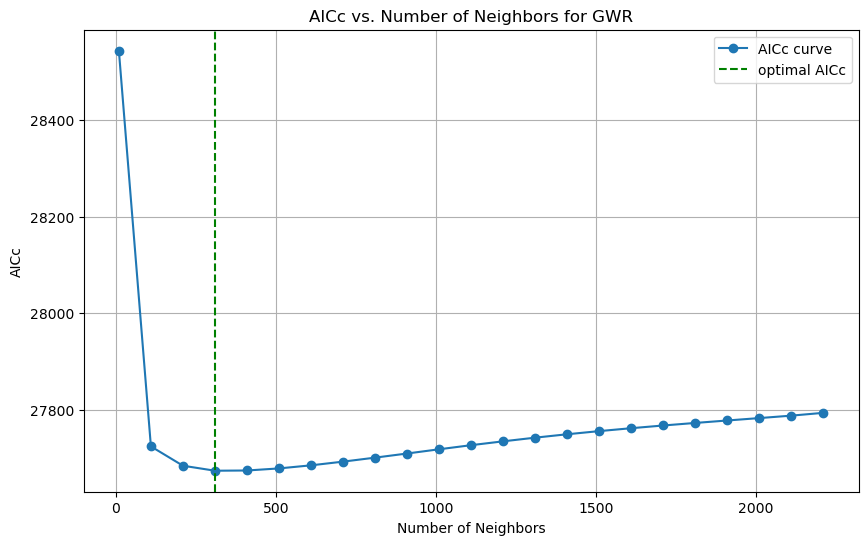

In [40]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors for GWR')
plt.grid(True)
plt.show()

In [41]:
params[0].shape

(2304, 1)

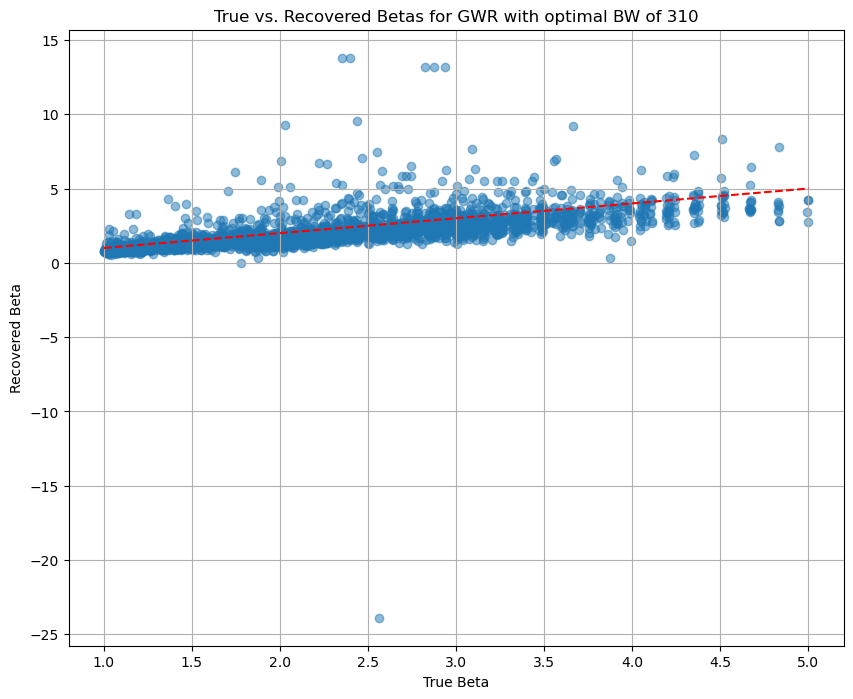

In [42]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

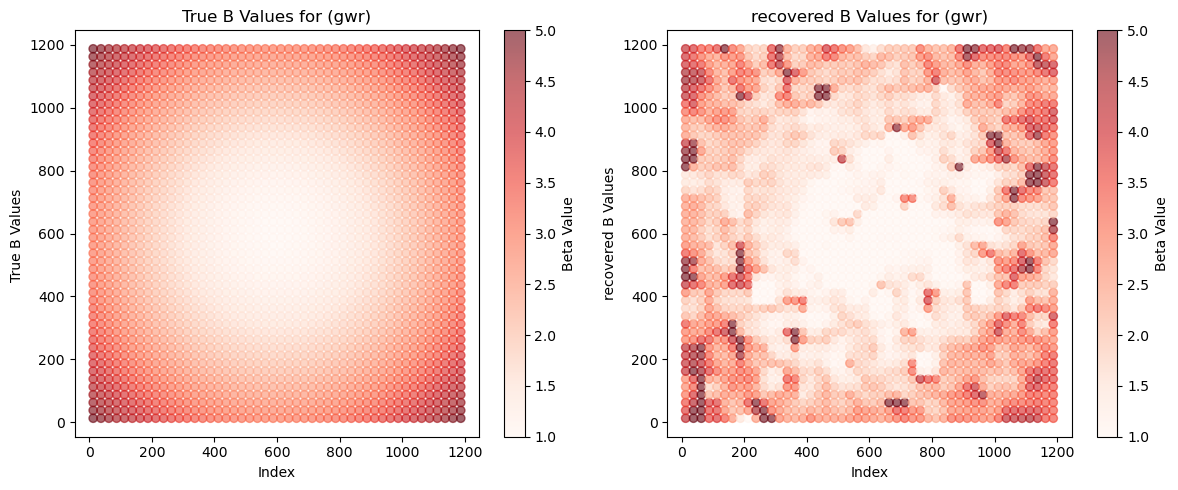

In [43]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr)')

In [44]:
B

array([4.998, 4.831, 4.672, ..., 4.675, 4.834, 5.   ])

In [45]:
params[0].round(1).flatten()

array([4.2, 3.8, 3.6, ..., 4.1, 2.8, 2.8])

In [46]:
B.min(), B.max()

(1.0, 5.0)

In [47]:
params[0].min(), params[0].max()

(-23.88296869110429, 13.803028766892876)

##### They both recover the true scale but GWR has more errors in recovering the true betas..

<br />

### Next experiment will be increasing the size of the tracts to 24x24 grids (576 tracts) and have the results compared

##### Here, i have increased the dimension to 24 x 24. It was previously 48 x 48. 

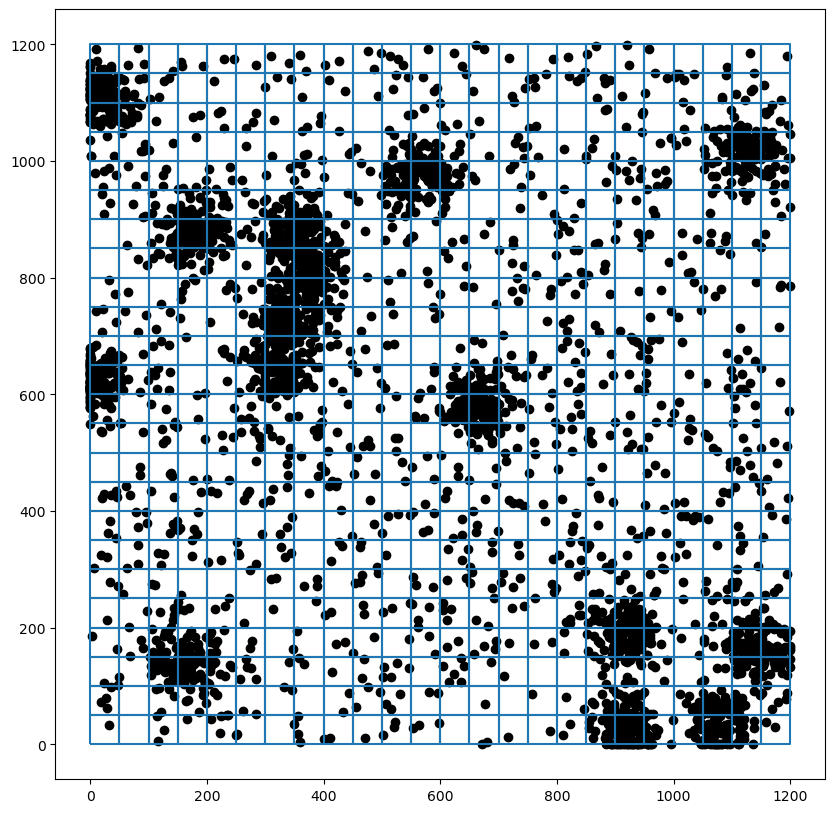

In [48]:
x_step, y_step = 50, 50  # Creates a 20x20 grid, resulting in 225 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)


y_24 = tracts_gdf48.copy()
y_24['y'] = y_orig

spj24 = gpd.sjoin(y_24, tracts_gdf24, how='left', predicate='within')
y_spj24 = spj24.groupby('tract_id_right')['y'].mean().values


S1 = tracts_gdf24
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='high')

# B = uniform(loc1)
tracts_gdf24.boundary.plot(figsize=(10, 10))
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [49]:
len(tracts_gdf24), len(S2)

(576, 3200)

In [50]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 10))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_spj24)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 32
Best AICc: 4877.68


In [51]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

32

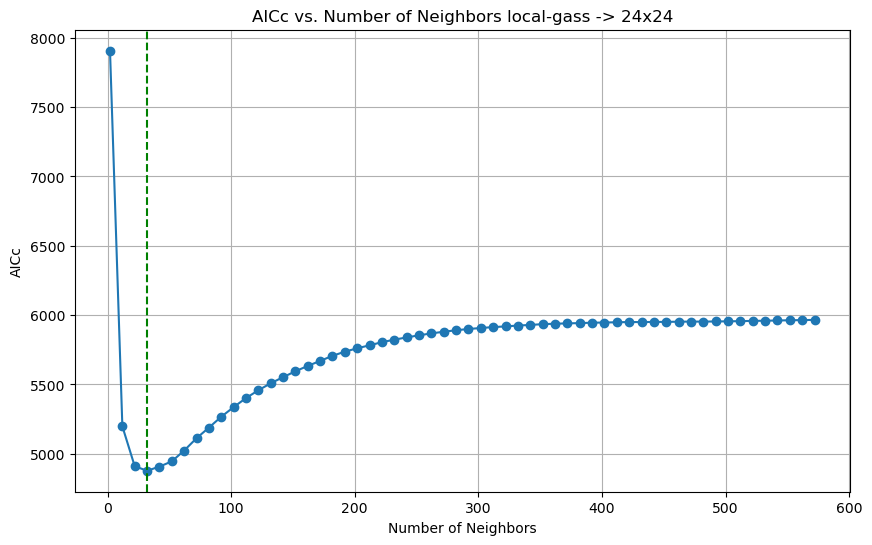

In [52]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 24x24')
plt.grid(True)
plt.show()

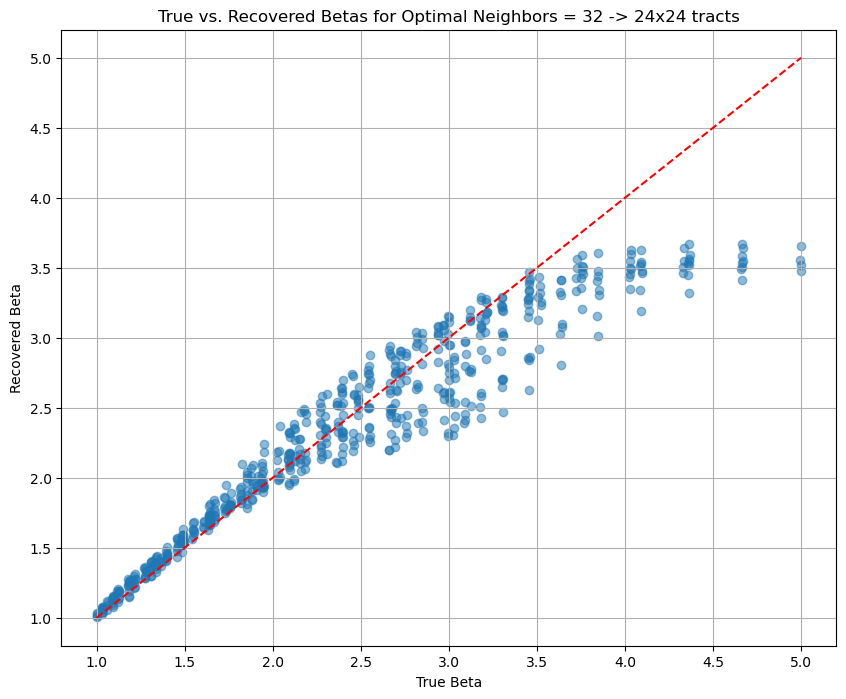

In [53]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} -> 24x24 tracts')
plt.grid(True)
plt.show()

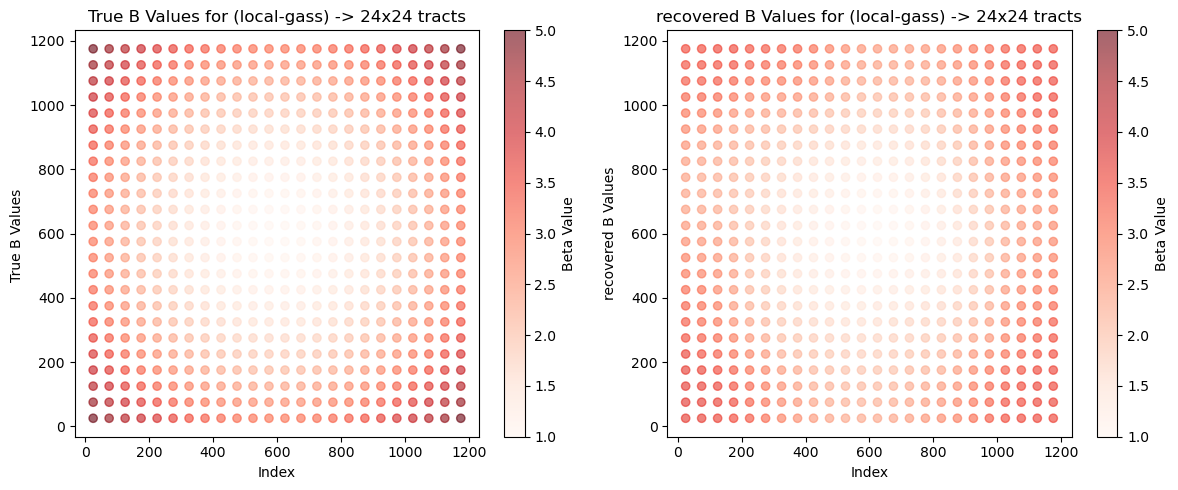

In [54]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 24x24 tracts')

In [55]:
B.min(), B.max()

(1.0, 5.0)

In [56]:
recovered_betas_best.min(), recovered_betas_best.max()

(1.0023844981028578, 3.672292187871053)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [57]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0}, inplace=True)

In [58]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 50.000 0.000, 50.000 50...  30.712859
1         1  POLYGON ((0.000 50.000, 50.000 50.000, 50.000 ...  46.312755
2         2  POLYGON ((0.000 100.000, 50.000 100.000, 50.00...  50.308825
3         3  POLYGON ((0.000 150.000, 50.000 150.000, 50.00...  45.069399
4         4  POLYGON ((0.000 200.000, 50.000 200.000, 50.00...  43.831490

##### Specify GWR parameters

In [59]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y_spj24.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((576, 1), (576, 1))

In [60]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 10))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [61]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [62]:
min(dict_aicc, key=dict_aicc.get)

70

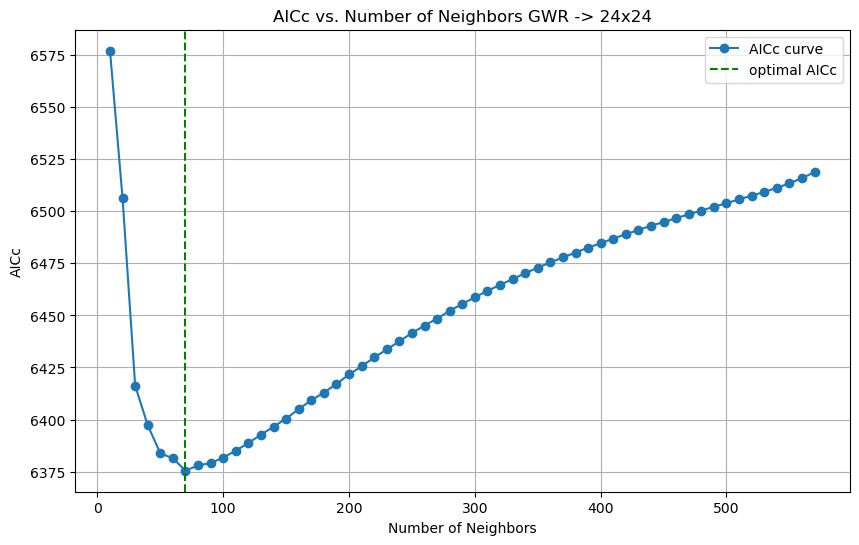

In [63]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR -> 24x24')
plt.grid(True)
plt.show()

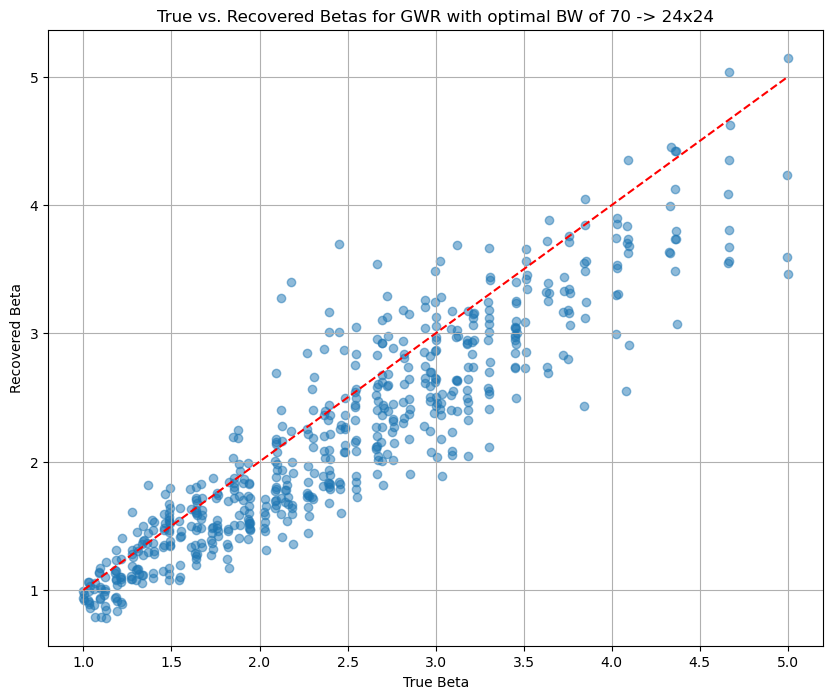

In [64]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 24x24")
plt.grid(True)
plt.show()

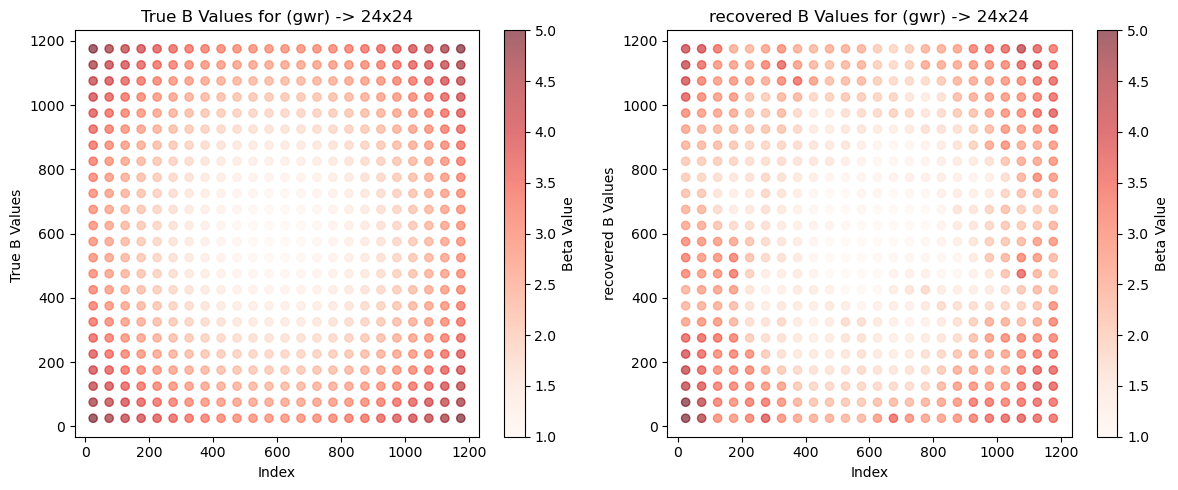

In [65]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 24x24')

In [66]:
B.min(), B.max()

(1.0, 5.0)

In [67]:
params[0].min(), params[0].max()

(0.7837324831342439, 5.148310123174598)

<b />

### Further increasing the size of the tracts to 16x16 grids (256 tracts) and have the results compared

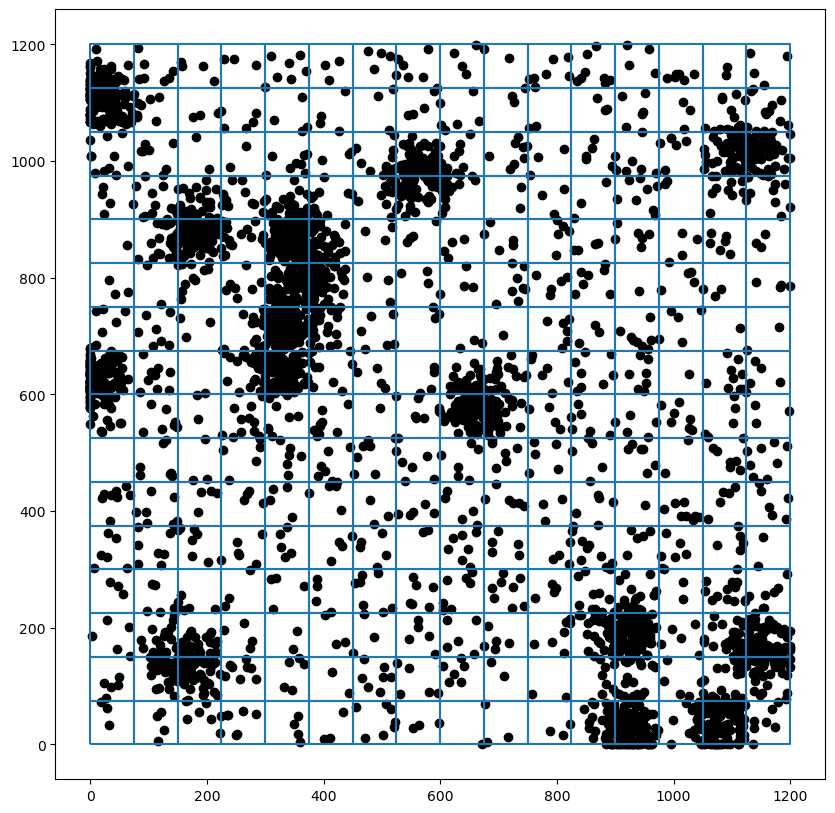

In [68]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 16x16 grid, resulting in 256 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

y_16 = tracts_gdf48.copy()  # make all of these a function. too much repetition
y_16['y'] = y_orig

spj16 = gpd.sjoin(y_16, tracts_gdf16, how='left', predicate='within')
y_spj16 = spj16.groupby('tract_id_right')['y'].mean().values # aggregate y values to 16x16 tracts

S1 = tracts_gdf16
S2 = S2
loc1 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='high')

tracts_gdf16.boundary.plot(figsize=(10, 10))
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [69]:
len(S1), len(y_spj16), len(S2)

(256, 256, 3200)

In [70]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 10))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_spj16)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 22
Best AICc: 2334.16


In [71]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

22

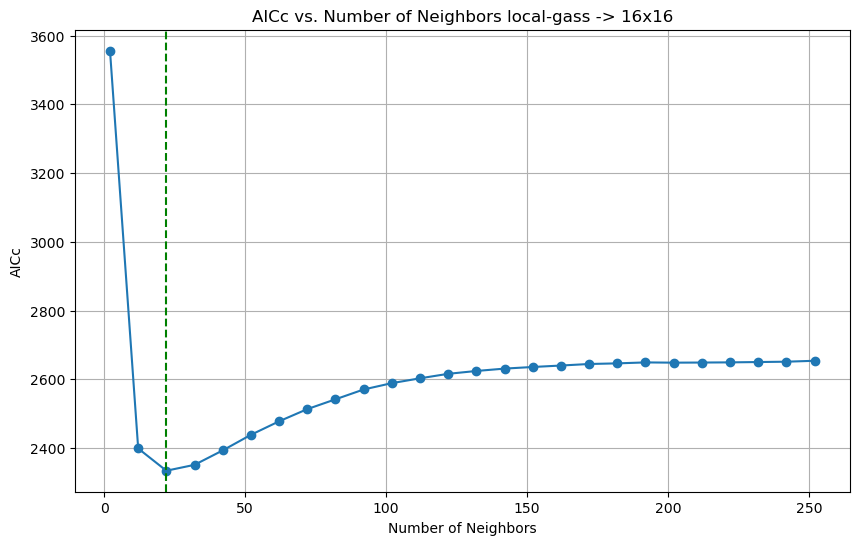

In [72]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 16x16')
plt.grid(True)
plt.show()

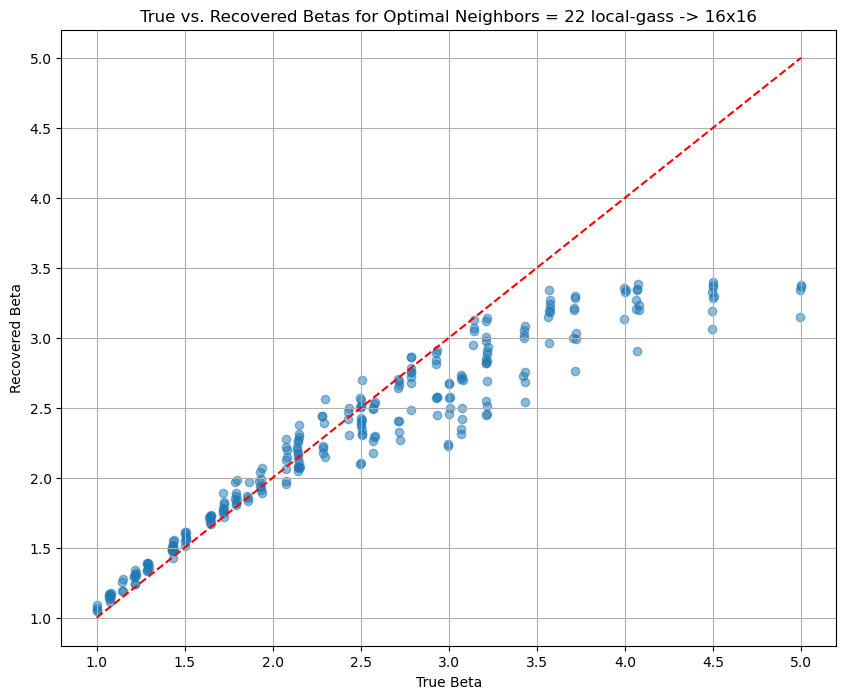

In [73]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 16x16')
plt.grid(True)
plt.show()

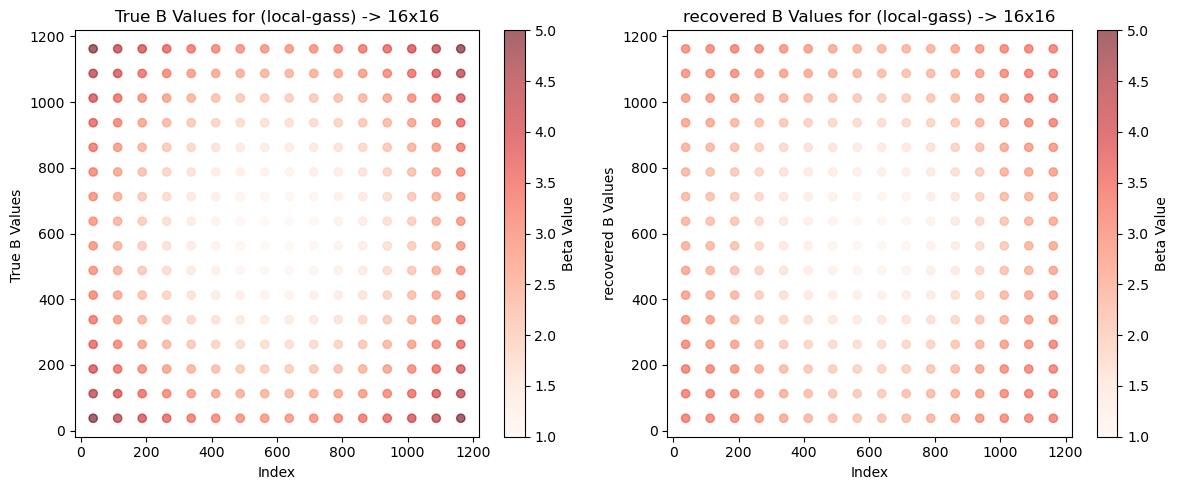

In [74]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 16x16')

In [75]:
B.min(), B.max()

(1.0, 5.0)

In [76]:
recovered_betas_best.min(), recovered_betas_best.max()

(1.0496154377130913, 3.4010568504845953)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [77]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0}, inplace=True)

In [78]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 75.000 0.000, 75.000 75...  42.846887
1         1  POLYGON ((0.000 75.000, 75.000 75.000, 75.000 ...  47.669939
2         2  POLYGON ((0.000 150.000, 75.000 150.000, 75.00...  35.350385
3         3  POLYGON ((0.000 225.000, 75.000 225.000, 75.00...  50.447014
4         4  POLYGON ((0.000 300.000, 75.000 300.000, 75.00...  56.057501

##### Specify GWR parameters

In [79]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y_spj16.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [80]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 10))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [81]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [82]:
min(dict_aicc, key=dict_aicc.get)

30

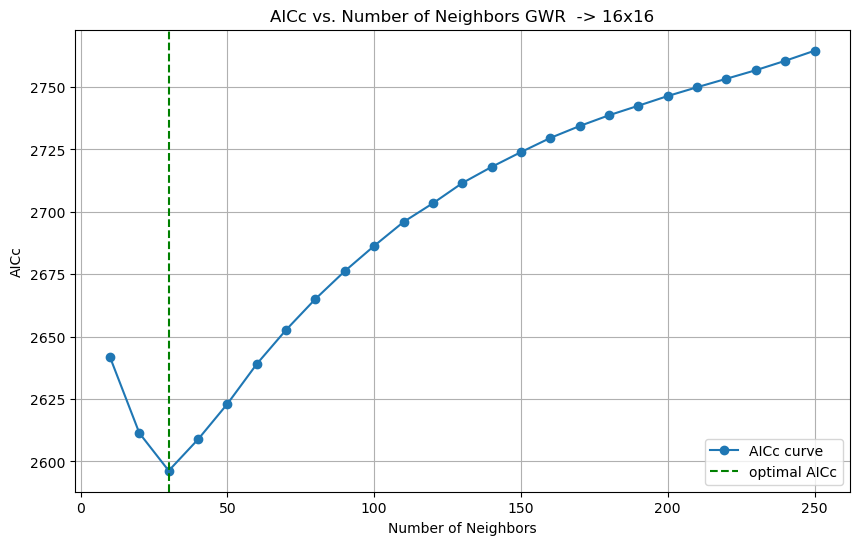

In [83]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 16x16')
plt.grid(True)
plt.show()

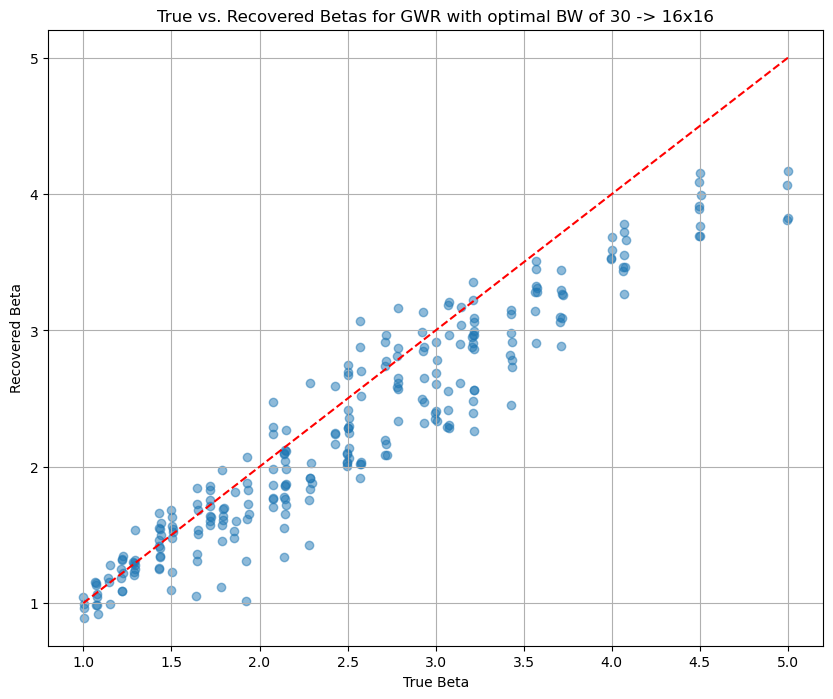

In [84]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 16x16")
plt.grid(True)
plt.show()

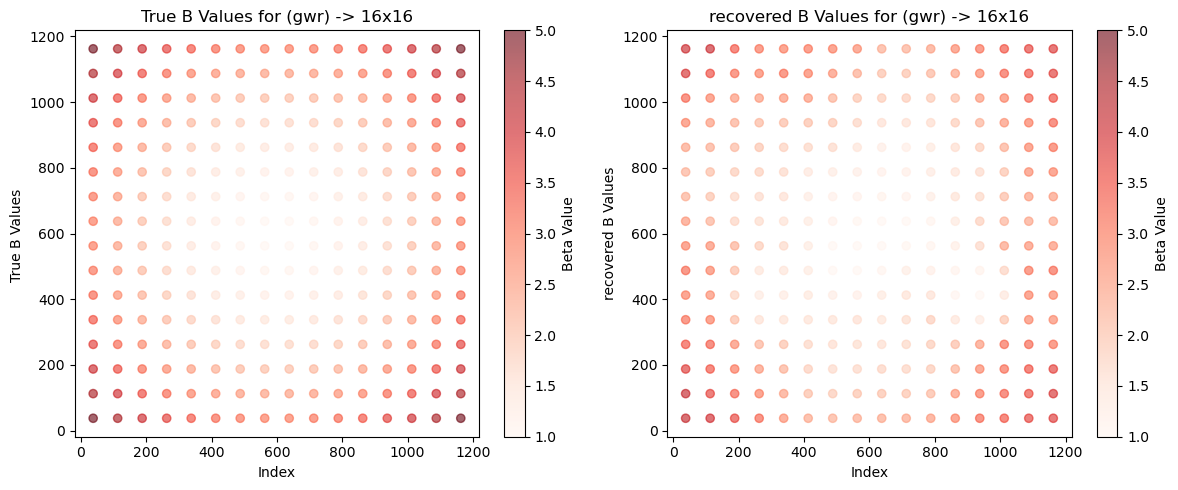

In [85]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 16x16')

In [86]:
B.min(), B.max()

(1.0, 5.0)

In [87]:
params[0].min(), params[0].max()

(0.892570363280689, 4.165503728608689)

<br >

### Further increasing the size of the tracts to 8x8 grids (64 tracts) and have the results compared

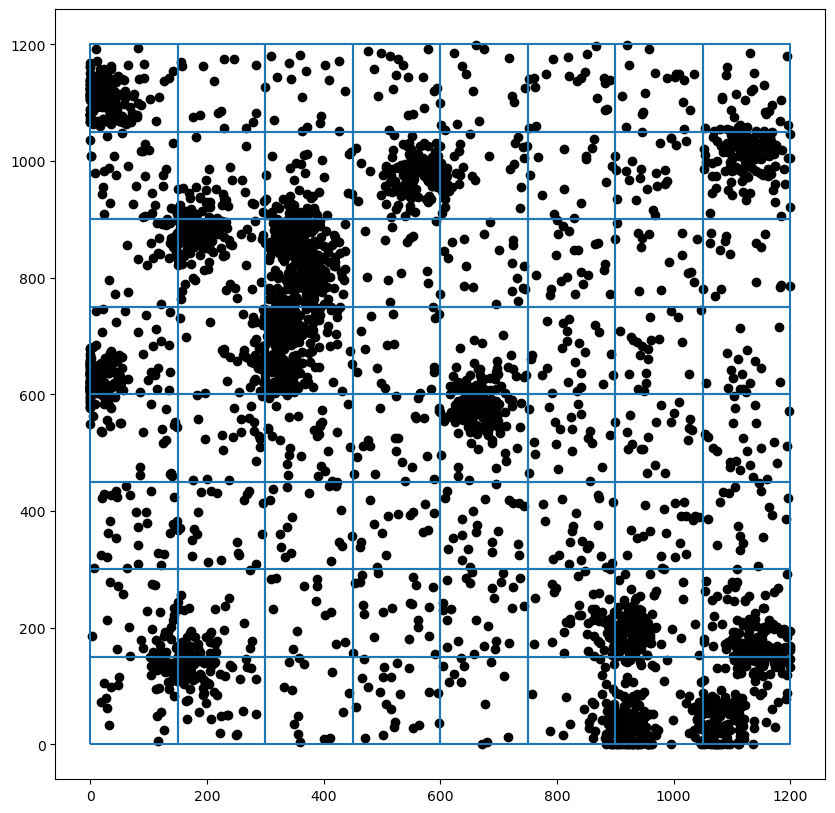

In [88]:
x_step, y_step = 150, 150  # Creates a 8x8 grid, resulting in 64 tracts
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
y_8 = tracts_gdf48.copy()  # make all of these a function. too much repetition
y_8['y'] = y_orig

spj8 = gpd.sjoin(y_8, tracts_gdf8, how='left', predicate='within')
y_spj8 = spj8.groupby('tract_id_right')['y'].mean().values

S1 = tracts_gdf8
S2 = S2
loc1 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])
loc2 = loc2

B = create_beta_surface(loc1, heterogeneity='high')

tracts_gdf8.boundary.plot(figsize=(10, 10))
plt.scatter(loc2[:,0], loc2[:,1], color='k');

In [89]:
len(S1), len(y_spj8), len(S2)

(64, 64, 3200)

In [90]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 4))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_spj8)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 18
Best AICc: 650.12


In [91]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

18

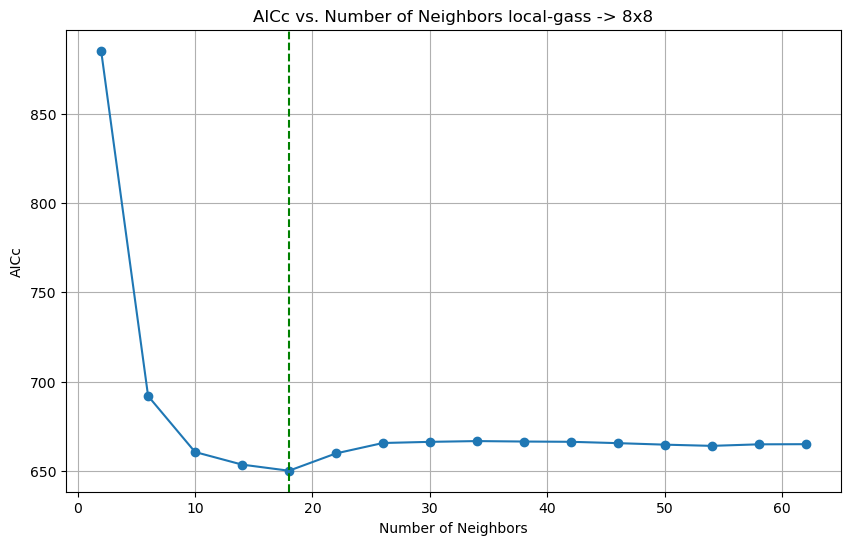

In [92]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 8x8')
plt.grid(True)
plt.show()

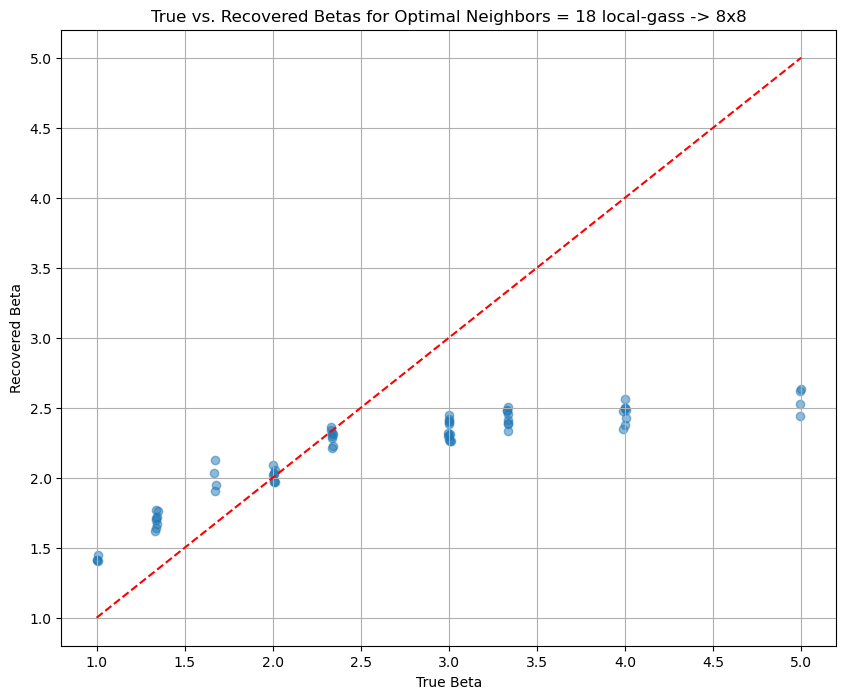

In [93]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 8x8')
plt.grid(True)
plt.show()

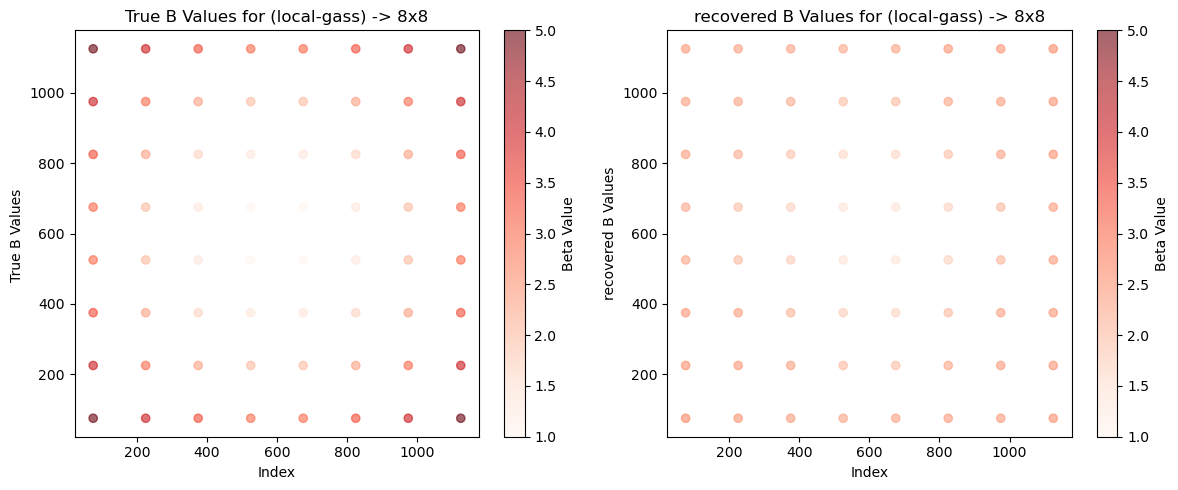

In [94]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 8x8')

In [95]:
B

array([5.   , 3.997, 3.328, 2.999, 3.005, 3.338, 3.997, 4.991, 4.005,
       2.999, 2.328, 2.001, 2.011, 2.343, 2.999, 3.99 , 3.334, 2.336,
       1.671, 1.339, 1.339, 1.672, 2.336, 3.333, 2.994, 2.006, 1.347,
       1.009, 1.   , 1.332, 2.006, 3.01 , 2.997, 2.006, 1.344, 1.008,
       1.002, 1.335, 2.005, 3.007, 3.338, 2.335, 1.667, 1.337, 1.343,
       1.676, 2.335, 3.329, 4.005, 2.999, 2.328, 2.001, 2.011, 2.343,
       2.999, 3.99 , 4.996, 3.998, 3.333, 3.001, 3.002, 3.334, 3.998,
       4.995])

In [96]:
recovered_betas_best.round(1)

array([2.6, 2.6, 2.5, 2.3, 2.3, 2.4, 2.4, 2.4, 2.5, 2.4, 2.4, 2. , 2. ,
       2.2, 2.3, 2.3, 2.4, 2.3, 2.1, 1.8, 1.7, 1.9, 2.2, 2.3, 2.3, 2. ,
       1.8, 1.4, 1.4, 1.6, 2. , 2.3, 2.3, 2. , 1.7, 1.4, 1.4, 1.6, 2. ,
       2.3, 2.4, 2.3, 2. , 1.7, 1.7, 2. , 2.3, 2.5, 2.4, 2.4, 2.3, 2.1,
       2.1, 2.3, 2.4, 2.5, 2.5, 2.5, 2.5, 2.4, 2.4, 2.5, 2.5, 2.6])

In [97]:
B.min(), B.max()

(1.0, 5.0)

In [98]:
recovered_betas_best.min(), recovered_betas_best.max()

(1.4061996872871503, 2.6307581736807566)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [99]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0}, inplace=True)

In [100]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 150.000 0.000, 150.000 ...  52.349793
1         1  POLYGON ((0.000 150.000, 150.000 150.000, 150....  52.240503
2         2  POLYGON ((0.000 300.000, 150.000 300.000, 150....  45.379782
3         3  POLYGON ((0.000 450.000, 150.000 450.000, 150....  35.869852
4         4  POLYGON ((0.000 600.000, 150.000 600.000, 150....  55.581642

##### Specify GWR parameters

In [101]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y_spj8.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [102]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(2, len(loc1), 4))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [103]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [104]:
min(dict_aicc, key=dict_aicc.get)

2

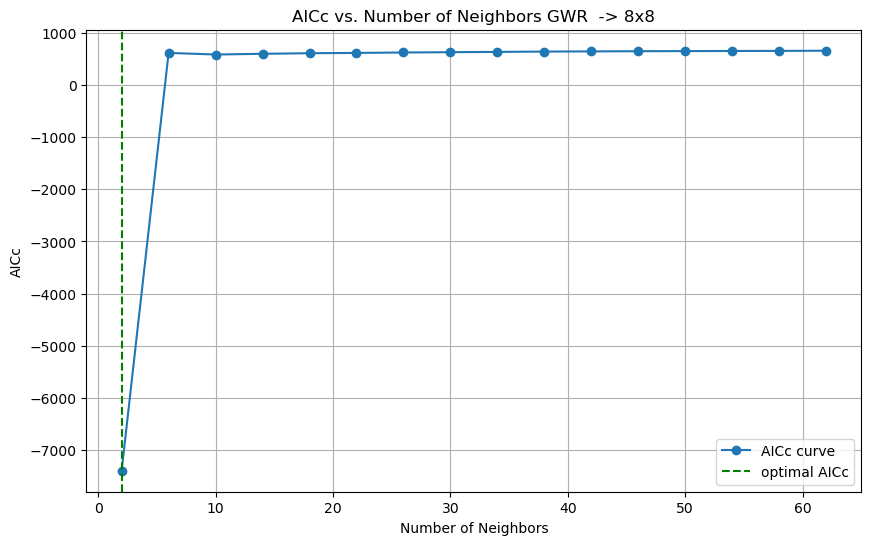

In [105]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 8x8')
plt.grid(True)
plt.show()

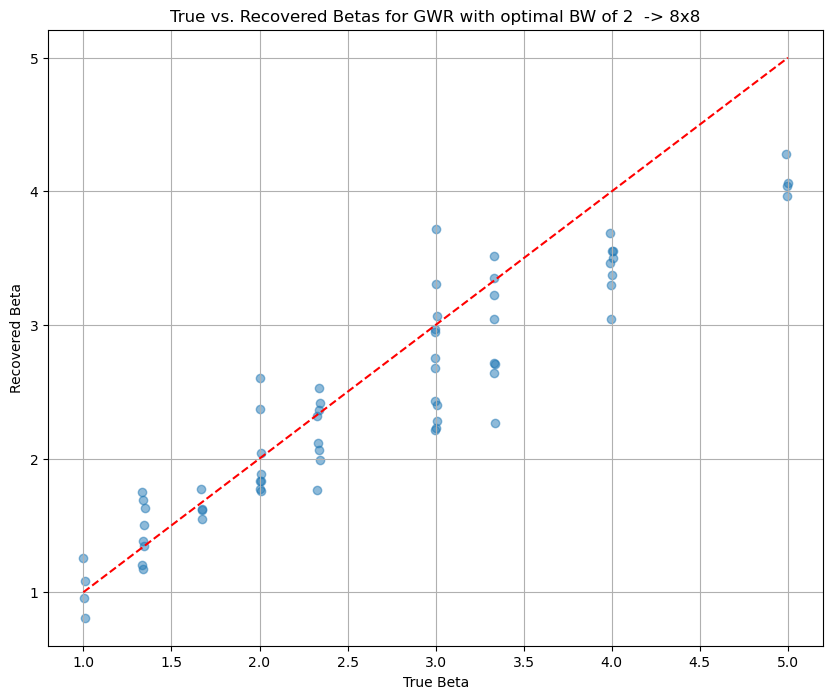

In [106]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}  -> 8x8")
plt.grid(True)
plt.show()

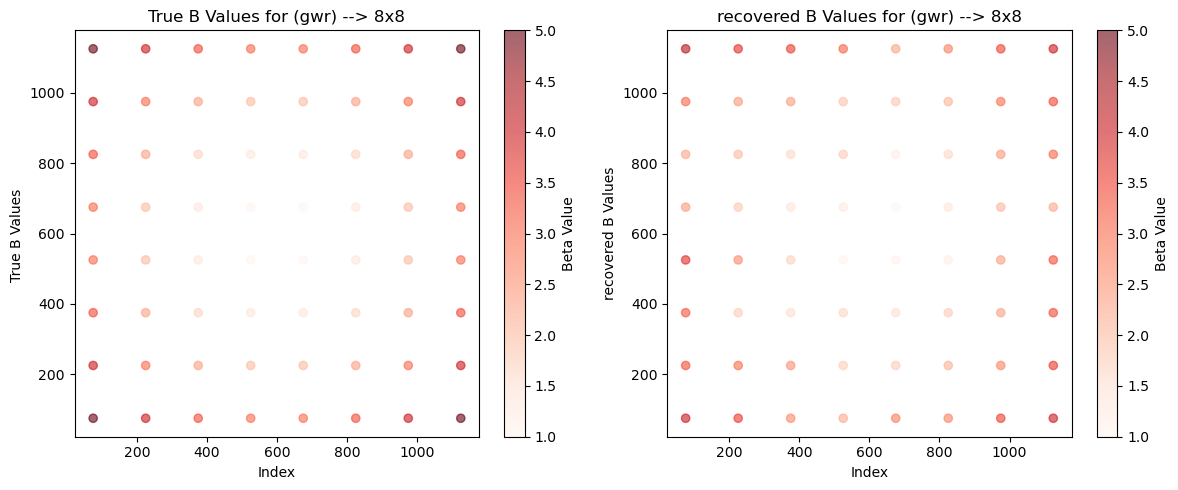

In [107]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) --> 8x8')

In [108]:
B.min(), B.max()

(1.0, 5.0)

In [109]:
params[0].min(), params[0].max()

(0.8090735521353164, 4.276610509441247)

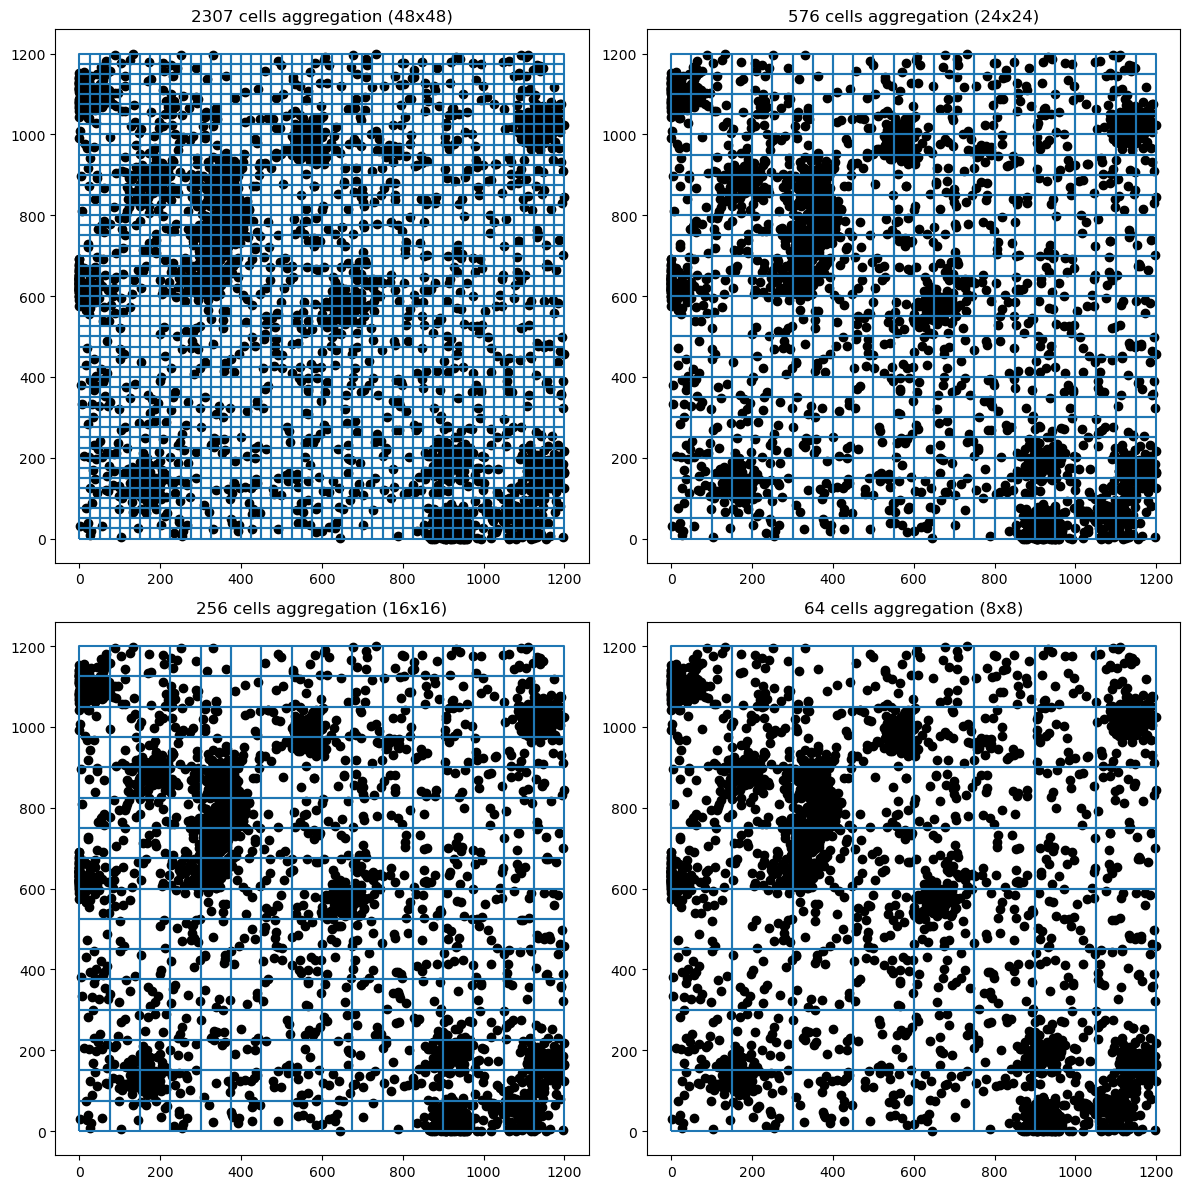

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create 2x2 grid of subplots

# 48x48 grid
x_step5, y_step5 = 25, 25  # 48x48 grid
tracts_gdf5 = create_tracts(xmin, xmax, ymin, ymax, x_step5, y_step5)
S25, loc25 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf5.boundary.plot(ax=axs[0, 0])  # Plot on top-left
axs[0, 0].scatter(loc25[:, 0], loc25[:, 1], color='k')
axs[0, 0].set_title('2307 cells aggregation (48x48)')

# 24x24 grid
x_step7, y_step7 = 50, 50  # 24x24 grid
tracts_gdf7 = create_tracts(xmin, xmax, ymin, ymax, x_step7, y_step7)
S27, loc27 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf7.boundary.plot(ax=axs[0, 1])  # Plot on top-right
axs[0, 1].scatter(loc27[:, 0], loc27[:, 1], color='k')
axs[0, 1].set_title('576 cells aggregation (24x24)')

# 16x16 grid
x_step9, y_step9 = 75, 75  # 16x16 grid
tracts_gdf9 = create_tracts(xmin, xmax, ymin, ymax, x_step9, y_step9)
S29, loc29 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf9.boundary.plot(ax=axs[1, 0])  # Plot on bottom-left
axs[1, 0].scatter(loc29[:, 0], loc29[:, 1], color='k')
axs[1, 0].set_title('256 cells aggregation (16x16)')

# 8x8 grid
x_step12, y_step12 = 150, 150  # 8x8 grid
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step12, y_step12)
S212, loc212 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf12.boundary.plot(ax=axs[1, 1])  # Plot on bottom-right
axs[1, 1].scatter(loc212[:, 0], loc212[:, 1], color='k')
axs[1, 1].set_title('64 cells aggregation (8x8)')

# Adjust layout
plt.tight_layout()
plt.show()
